In [5]:
import sys
import os
from IPython.display import Image

PATH = ""

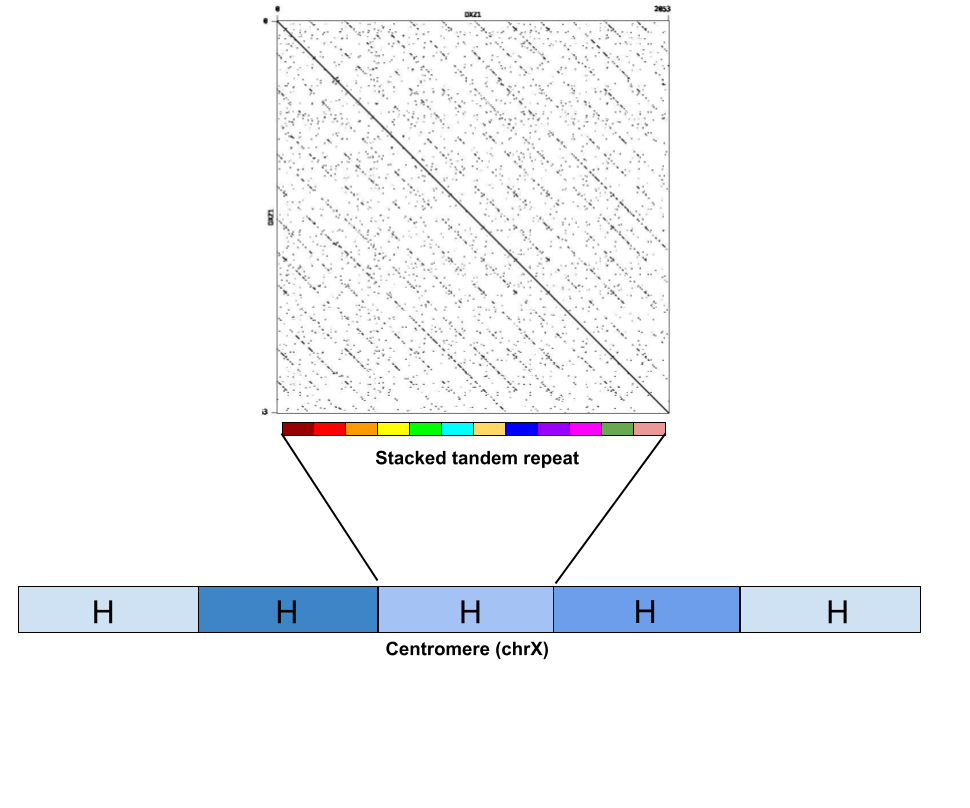

In [7]:
Image(filename=os.path.join(PATH, "ManualPics", "Figure1.png"))